<a href="https://colab.research.google.com/github/changsin/ClassifyImages/blob/main/notebooks/cluster_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Images

Clustering is a popular unsupervised learning algorithm often used in preprocessing data. To cluster similar items in the same group, two things are needed:

1. Features: Features are decided according to data types and purposes. Regardless of data type and features, they all need to be represented in vectors.
2. Distance functions: once the features are decided and converted into vector forms, you have to decide which distance function you want to use to measure the distance between two feature vectors. Popular distance functions are: Euclidean, Cosine, Manhattan, and Hamming.

In our case, the data types are images so we can use either pixel values or structures in images. For distance functions, we will try Euclidean and Cosine functions to compare the differences. 

# The Datasets
We will use three sample datasets.

### 1. Night and day images
We have two datasets: daytime and nighttime highway images and vehicle images downloaded from [unsplash](https://unsplash.com/):

- 5 daytime image
- 5 nighttime images)

### 2. Highway surveillance camera images
These pictures are taken from a highway CCTV camera with two settings:

- Zoom-in
- Zoom-out

### 3 Vehicle images
For a more challenging experiment, I downloaded sixteen vehicle images from [unsplash](https://unsplash.com/).

- 8 VW Microbus
- 8 VW Beetles

Ideally, we want to see Microbuses and Beetles to belong to their own clusters. Let's see if we can do that through clustering.

The sample data downloaded and resized to be included in this repository.

In [3]:
!git clone https://github.com/changsin/ClassifyImages

fatal: destination path 'ClassifyImages' already exists and is not an empty directory.


## Load and visualize images
Let's first load and visualize the data.

In [1]:
import argparse
import glob
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist
from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

"""
Methods for loading and visualizing images
"""

IMAGE_SIZE = 320

def glob_files(folder, file_type='*'):
    search_string = os.path.join(folder, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

def load_images(path, file_type="*"):
    files = glob_files(path, file_type)

    images = []
    for file in files:
        # print(file)
        image = cv2.imread(file)
        if image is not None:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            # normalize
            image = image / 255
            images.append(image)
        else:
            print(file, ' is not an image file')

    return np.array(images)

def plot_images(X, idx=None, limit=20):
  fig = plt.figure(figsize=(20,20))

  # The number of images for plotting is limited to 50
  end_id = len(X) if len(X) < limit else limit
  if idx is None:
    idx = range(0, end_id)

  i = 0
  for id in idx:
    axis = fig.add_subplot(4, 4, i+1)
    plt.axis('off')
    image = X[id]
    plt.imshow(image)
    i += 1

# Features

## Pixels as features
Let's first consider what the features should be. In other words, what do we want to use as feature vectors to run the clustering algorithm. Since the data type is image, they are loaded as multi-dimensional arrays already so the default choice is to use them as they are.

Running a clustering algorithm is easy with sklearn library which provides several clustering algorithms. Let's use KMeans which is probably the most popular. For visualization purposes, we will also run PCA (Principle Component Analysis) to reduce the dimension to two so that we can plot the clusters as x and y coordinates. Below is the implemention.

```
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
```

In [2]:
def get_pca_reduced(X_features, dimensions=2):
  X_features_flatten = X_features.reshape(X_features.shape[0], -1)
  pca = PCA(dimensions)

  X_features_pca_reduced = pca.fit_transform(X_features_flatten)

  return X_features_pca_reduced, pca


def get_clusters(X_reduced, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X_reduced)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(path, K=2):
  X = load_images(path)
  plot_images(X)
  X_reduced, pca = get_pca_reduced(X, dimensions=K)

  X_clusters, kmeans = get_clusters(X_reduced, K)

  # get the image ids of each cluster
  cluster_idx = to_cluster_idx(X_clusters.labels_, range(K))

  # keep the cluster centers
  print(kmeans.cluster_centers_)
  print(cluster_idx)
  
  return X_reduced, kmeans

Here is the code for plotting the clusters.

In [21]:
import matplotlib.pyplot as plt

def plot_data_in_clusters(data, kmeans, idx=None, show_centroids=True):
  marker_size = 7

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = data[:, 0].min(), data[:, 0].max()
  y_min, y_max = data[:, 1].min(), data[:, 1].max()

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  h = float((x_max - x_min)/100)

  PADDING = h + marker_size
  x_min, x_max = x_min - PADDING, x_max + PADDING
  y_min, y_max = y_min - PADDING, y_max + PADDING

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(data[:, 0], data[:, 1], 'k.', markersize=marker_size)

  if show_centroids:
    markers = ["o", "1"]
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    for id in range(len(centroids)):
      c = centroids[id]
      plt.scatter(c[0], c[1], marker=markers[id], s=150, linewidths=marker_size,
                  color="w", zorder=10)
  if idx:
    for id in idx:
        plt.scatter(data[id, 0], data[id, 1], marker="x",
                    s=150, linewidths=marker_size,
                    color="w", zorder=10)

  plt.title("K-means clustering")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

### Day and night images
Using pixels as feature vectors should work well for day and night images of highways. Our intuition is that daytime images tend to have bigger pixel values than nighttime images and thus the algorithm was able to find natural clusters. Let's see if the algorithm confirms our intuition.


In [ ]:
path_daynight = '/content/ClassifyImages/data/daynight'

X_reduced_daynight, kmeans_daynight = cluster_images(path_daynight)
plot_data_in_clusters(X_reduced_daynight, kmeans=kmeans_daynight)

### Highway CCTV images
The data come from a public dataset of highway surveillance images. There are two types of settings: zoom-out and zoom-in. The images from these two settings have very distinct characteristics. Let's run the clustering algorithm to see if it can do it. 

The sample dataset resides in a different repository so let's clone it.

In [5]:
!git clone https://github.com/changsin/DLTrafficCounter

fatal: destination path 'DLTrafficCounter' already exists and is not an empty directory.


In [ ]:
path_traffic = '/content/DLTrafficCounter/data/bbox_highway/test'

X_reduced_tr, kmeans_tr = cluster_images(path_traffic)
plot_data_in_clusters(X_reduced_tr, kmeans=kmeans_tr)

Beautiful! Without any training, the clustering algorithm neatly divided the images into two distinct clusters. So far so good.

### Car images
The car images, however, pose challenges. Let's take a look at the images to see why.

In [ ]:
path_cars = '/content/ClassifyImages/data/cars'

images = load_images(path_cars)
images.shape
plot_images(images)

In [8]:
# images = load_images(path_daynight)
# images.shape

In [9]:
# images.reshape(images.shape[0], -1).shape


In [10]:
# K = 2

# images_flattened = images.reshape(images.shape[0], -1)

# pca = PCA(K)

# X_reduced = pca.fit_transform(images_flattened)

# kmeans = KMeans(n_clusters=K, random_state=0)
# clusters_cars = kmeans.fit(X_reduced)
# clusters_cars

In [11]:
# plot_data_in_clusters(X_reduced, kmeans)

Though we can tell that there are two different model types, the background, color, locations, and angles are all different. Let's see how the clustering algorithm does based purely on pixel values. 

In [ ]:
X_reduced_cars, kmeans_cars = cluster_images(path_cars)
plot_data_in_clusters(X_reduced_cars, kmeans=kmeans_cars)

In [ ]:
images = load_images(path_cars)
plot_images(images, idx=[0,  1,  3,  4, 13, 15])

In [ ]:
plot_images(images, idx=[2,  5,  6,  7,  8,  9, 10, 11, 12, 14])

What happened? Though the algorithm ran without any error, the data points are scattered quite randomly around the latent space. What we wished to see some natural clusters instead. The reason should be obvious. In the day and night images, we were lucky because the magnitude of individual pixel values served as the pivoting criterion. In the case of cars, they were all taken during the day against complex backgrounds. Though we as humans could recognize different car model types, for the computers, they are just random pixel values and thus no natural clustering groups emerged.

What we need is a way for the machines to recognize structures inherent in images. For this, we are turning to CNN (Convolutional Neural Network). 


## CNN for feature maps
CNN is widely used to analyze images. An image is passed through a series of convolutions which act as filters to extract "feature maps." These feature maps are used as the input to the subsequent layers in the model to perform higher level cognition tasks such as object detection. Here is the diagram of VGG-16 which is one of the earliest CNN models.


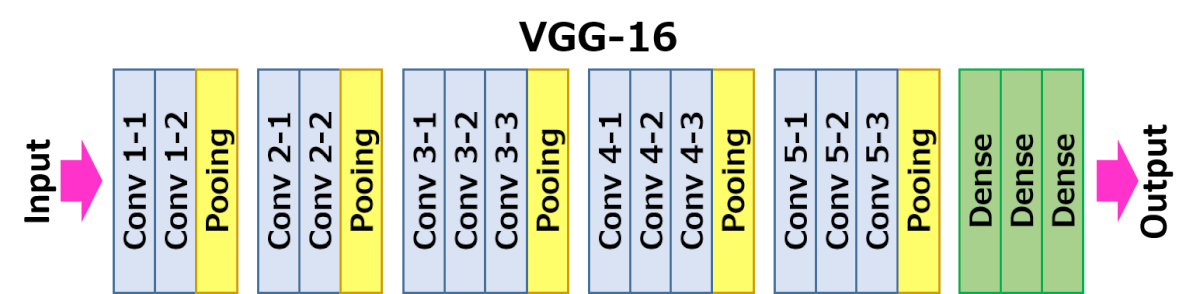

[image source](https://neurohive.io/en/popular-networks/vgg16/)

The convolutional layers comprise the majority of VGG-16 layers except the last three. To see the effect of convolutions. Let's intercept one of the convolution outputs and visualize them. Here is the method to intercept the CNN output. You can specify the layer number from which you want to extract the CNN output. 

### Visualize CNN outputs

In [15]:
def get_cnn_output(X, layer=1):
  """
  returns the CNN output from the specified layer
  """
  #Convert to VGG input format
  X = preprocess_input(X)

  #include_top=False == not getting VGG16 last 3 layers
  model = VGG16(weights="imagenet", include_top=False)

  model = Model(inputs=model.inputs, outputs=model.layers[layer].output)
  model.summary()
  features = model.predict(X)
  # print(features.shape)

  return features

In [16]:
cnn_results = get_cnn_output(images)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


It returns output vectors of size 64, each of which represents the result of a particular convolution. Let's take a look at a couple of them. Some outputs are not quite humanly recognizable, but here are a few that seem to make sense to a human eye. 

In [ ]:
plot_images([cnn_results[0][:, :, 1], cnn_results[0][:, :, 22], cnn_results[0][:, :, 27], cnn_results[0][:, :, 50]])

We can see that each convolution operation is picking up particular aspect of the input image though we could not articulate exactly what they are. We visualized the output results from the first convolutional layer. The results are then fed into subsequent convolution layers all the way excep the last three layers. For our purposes, we will take the last output from the convolutional layer as the feature maps for clustering. Below is the code for extracting and then clustering with feature maps.

In [18]:
def to_feature_maps(path, file_type="*"):
    def _to_feature_maps(X):
        #Convert to VGG input format
        X = preprocess_input(X)

        #include_top=False == not getting VGG16 last 3 layers
        model = VGG16(weights="imagenet", include_top=False)

        return model.predict(X)

    files = glob_files(path, file_type)

    files_processed = []
    feature_maps = []
    for file in files:
        # print(file)
        image = cv2.imread(file)
        if image is not None:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            image = image / 255
            # doing it one at a time to reduce the memory foot print
            fm = _to_feature_maps(np.array([image]))
            feature_maps.append(fm)

            files_processed.append(file)
        else:
            print(file, ' is not an image file')

    return np.array(feature_maps), files_processed

def cluster_images_fm(path, K=2, cosine_distance=True):
  X_fm, files = to_feature_maps(path)

  # # normalize to use cosine similarity
  if cosine_distance:
    X_fm = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

  X_reduced_fm, pca_fm = get_pca_reduced(X_fm, dimensions=K)

  X_clusters_fm, kmeans_fm = get_clusters(X_reduced_fm, K)

  # get the image ids of each cluster
  cluster_idx_fm = to_cluster_idx(X_clusters_fm.labels_, range(K))

  # keep the cluster centers
  print(kmeans_fm.cluster_centers_)
  print(cluster_idx_fm)

  return X_reduced_fm, kmeans_fm

In [19]:
def get_feature_maps(X):
    #Convert to VGG input format
    # X_pre = preprocess_input(X)

    #include_top=False == not getting VGG16 last 3 layers
    model = VGG16(weights="imagenet", include_top=False)

    return model.predict(X)

In [20]:
images = load_images(path_cars)

# Distance functions

### Euclidean distance

Let's run the same algorithm with the feature maps using Euclidean distance which is the default distance function.

The formula for calculating the Euclidean distance is:

$ d(p1, p2) = \sqrt{\sum \limits_{i=1}^{N} (p2_i - p1_i)^2} $
- d: distance
- p, q: two points (vectors)
- N: dimensions

In x, y coordinates, the formula is:
$ d(p1, p2) = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2} $


In [ ]:
X_reduced_cars, kmeans_cars = cluster_images_fm(path_cars, K=2, cosine_distance=False)
plot_data_in_clusters(X_reduced_cars, kmeans=kmeans_cars)

Though there are a few confused cases, 6/8 Beetles and 6/8 Microbuses are clustered together correctly.

In [ ]:
plot_images(images, idx=[ 0,  2,  3,  4,  6,  7,  9, 15])

In [ ]:
plot_images(images, idx=[ 1,  5,  8, 10, 11, 12, 13, 14])

In [ ]:
plot_data_in_clusters(X_reduced_cars, kmeans=kmeans_cars, idx=[8, 9])

### Cosine distance
Let's run the algorithm again but with cosine distance this time. The cosine distance function is:


$$ cos\theta = \frac{xy}{|x||y|} $$

This is called the cosine similarity because it tells you the difference between two normalized vectors. The bigger the number is the more similar. If there is no similarity, they are orthogonal and the result is zero.


By flipping the nominator and the denominator, we can use it as a distance measure:

$$ d(x, y) = \frac{|x||y|}{xy} $$

In this case, the smaller the number is, the more similar. 

Running with cosine distance (normalization) did not change the clusters in this case.

In [26]:
X_reduced_cars_co, kmeans_cars_co = cluster_images_fm(path_cars, K=2, cosine_distance=True)
plot_data_in_clusters(X_reduced_cars_co, kmeans=kmeans_cars_co)

[[ 0.01173502 -0.00040805]
 [-0.01173502  0.00040805]]
{0: array([ 1,  5,  8, 10, 11, 12, 13, 14]), 1: array([ 0,  2,  3,  4,  6,  7,  9, 15])}


In [ ]:
plot_data_in_clusters(X_reduced_cars_co, kmeans=kmeans_cars_co)

In [ ]:
images = load_images(path_cars)

In [ ]:
plot_images(images, idx=[1,  5,  8, 10, 11, 12, 13, 14])

Then run the clustering algorithm with simple pixel values and feature maps.

In [ ]:
X_reduced_trfm, kmeans_trfm = cluster_images_fm(path_traffic, K=2, cosine_distance=True)
plot_data_in_clusters(X_reduced_trfm, kmeans=kmeans_trfm)

Though the shape of the clusters are different, the results are identical.

In [ ]:
plot_images(images, idx=[0,  2,  3,  4,  6,  7,  9, 15])

# Find similar images

Clustering gives you more than just grouping of similar items. Since it uses a distance function to calculate similarities, we can actually use to find similar images or even find duplicate images where the similarity is an identity.

To find similar items in the dataset, we need to build NxN matrix of relative distances between all data pairs.

find_min_max() calculates the distance pairs and find the minimum (most similar) and the maximum (most different) pairs.

In [ ]:
def find_min_max(X_data):
  # Calculate distances of all points
  distances = cdist(X_data, X_data)

  rows = distances.shape[0]

  max_id1 = int(np.argmax(distances)/rows)
  max_id2 = np.argmax(distances[max_id1])

  # use the max value to set the zero value of the diagonal 
  max = np.max(distances)

  for row_id in range(distances.shape[0]):
    distances[row_id, row_id] = max

  min_id1 = int(np.argmin(distances)/distances.shape[0])
  min_id2 = np.argmin(distances[min_id1])

  print("min: {} {}".format((min_id1, min_id2), distances[min_id1, min_id2]))
  print("max: {} {}".format((max_id1, max_id2), distances[max_id1, max_id2]))

  return (min_id1, min_id2), (max_id1, max_id2)

Running against the car dataset, we find two similar images easily.

In [ ]:
(min_id1, min_id2), (max_id1, max_id2) = find_min_max(X_reduced_cars)
plot_data_in_clusters(X_reduced_cars, kmeans=kmeans_cars, idx=[4, 9])

In this case, they are not quite similar to a human observer.

In [ ]:
plot_images(images, [4, 9])

Let's try cosine distance.

In [ ]:
(min_id1, min_id2), (max_id1, max_id2) = find_min_max(X_reduced_cars_co)
plot_data_in_clusters(X_reduced_cars_co, kmeans=kmeans_cars_co, idx=[8, 10])

In [ ]:
plot_images(images, [8, 10])

In this case, they do look quite similar. So we may conclude that cosine distance function is a good fit for this dataset in finding similarities.

# Find duplicates
Using the same distance function, we can find duplicate images too. Duplicate images can be identical images or very similar images. In either case, the distance function will return very small number (close to zero). With this information, here is the code for finding duplicate images.

In [ ]:
def find_duplicates(X_train_pca, threshold=0.1):
    # Calculate distances of all points
    distances = cdist(X_train_pca, X_train_pca)

    # Find duplicates (very similar images)
    # dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)
    dupes = [np.array(np.where(distances[id] < threshold)).reshape(-1).tolist() \
            for id in range(distances.shape[0])]

    to_remove = set()
    for d in dupes:
        if len(d) > 1:
            for id in range(1, len(d)):
                to_remove.add(d[id])
    logger.info("Found {} duplicates".format(len(to_remove)))
    return to_remove